In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch # Importiamo la libreria per il dendrogramma

# Configurazione stile grafici
plt.style.use('seaborn-v0_8')

# 1. Caricamento
df = pd.read_csv('data/puliti/movimento_fe.csv')

# 2. Definizione Feature
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_exclude = [
    'ID', 'Age', 'OVR', 'Weak Foot', 'Skill Moves'
]
features_to_use = [col for col in numeric_cols if col not in cols_to_exclude]
X_all = df[features_to_use].fillna(df[features_to_use].mean())

# 3. Rimozione Ridondanze
corr_matrix = X_all.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
final_features = [f for f in features_to_use if f not in to_drop]

# 4. Filtro OVR (Top Players)
soglia_ovr = 75
df_top = df[df['OVR'] >= soglia_ovr].copy()
X_top = df_top[final_features].fillna(df_top[final_features].mean())

# 5. Scaling e PCA
scaler = StandardScaler()
X_top_scaled = scaler.fit_transform(X_top)
pca = PCA(n_components=3)
X_top_pca = pca.fit_transform(X_top_scaled)

print(f"Dati 'Top Players' pronti: {X_top_pca.shape[0]} giocatori, {X_top_pca.shape[1]} dimensioni (PCA).")

Dati 'Top Players' pronti: 2086 giocatori, 3 dimensioni (PCA).


Calcolo della matrice di linkage per il Dendrogramma...
Disegno del Dendrogramma...


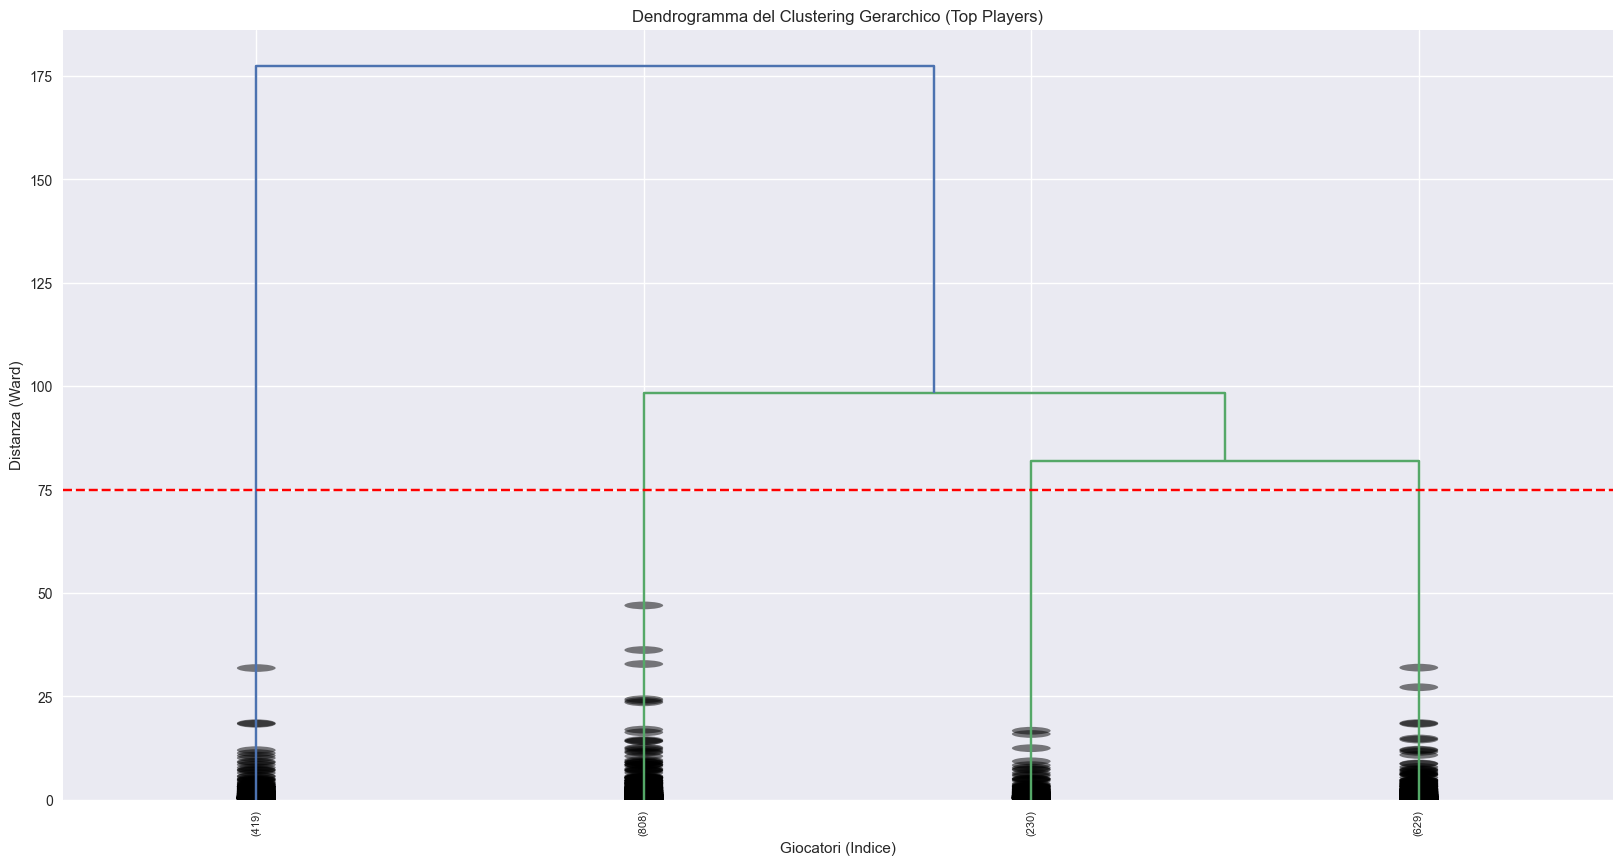

In [2]:
print("Calcolo della matrice di linkage per il Dendrogramma...")

# Usiamo il metodo 'ward' che minimizza la varianza (simile a K-Means)
# È computazionalmente intensivo
linkage_matrix = sch.linkage(X_top_pca, method='ward')

print("Disegno del Dendrogramma...")
plt.figure(figsize=(20, 10))
plt.title('Dendrogramma del Clustering Gerarchico (Top Players)')
plt.xlabel('Giocatori (Indice)')
plt.ylabel('Distanza (Ward)')

# 'p=4' tronca il dendrogramma per mostrare solo gli ultimi 4 livelli di fusione
# (altrimenti 2086 foglie sarebbero illeggibili)
# 'truncate_mode='lastp'' significa che mostra gli ultimi p cluster formati
sch.dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # Mostra solo gli ultimi 'p' cluster fusi
    p=4,                    # Impostiamo p=4 per vedere i 4 gruppi principali
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,   # Mostra i cluster contratti
)

# Tracciamo una linea orizzontale per mostrare dove "taglieremmo" per ottenere 4 cluster
# Questa linea (threshold) è il punto chiave
# (Il valore 75 è un esempio, dovrai aggiustarlo guardando il grafico)
plt.axhline(y=75, color='r', linestyle='--') 

plt.show()

In [3]:
# 3. Esecuzione dell'Algoritmo
# Invece di 'K', gli diciamo 'n_clusters=4'
# Lo applichiamo sempre ai dati PCA (X_top_pca)
agg_cluster = AgglomerativeClustering(n_clusters=4, linkage='ward')
cluster_labels_agglo = agg_cluster.fit_predict(X_top_pca)

df_top['Cluster_Gerarchico'] = cluster_labels_agglo

# Calcoliamo la Silhouette per confrontarla con K-Means
silhouette_agglo = silhouette_score(X_top_pca, cluster_labels_agglo)
print(f"Silhouette Score (Gerarchico, K=4): {silhouette_agglo:.4f}")

Silhouette Score (Gerarchico, K=4): 0.2627


In [4]:
print("\n--- ANALISI TATTICA (Gerarchico K=4) ---")
print("Righe: Cluster Trovati, Colonne: Ruoli Reali")
crosstab_gerarchico = pd.crosstab(df_top['Cluster_Gerarchico'], df_top['Position'])
display(crosstab_gerarchico)


--- ANALISI TATTICA (Gerarchico K=4) ---
Righe: Cluster Trovati, Colonne: Ruoli Reali


Position,CAM,CB,CDM,CM,LB,LM,LW,RB,RM,RW,ST
Cluster_Gerarchico,,,,,,,,,,,
0,144,0,23,136,22,112,67,19,105,76,104
1,0,359,19,2,17,0,0,22,0,0,0
2,12,61,166,154,98,8,0,117,11,1,1
3,4,0,0,1,1,3,3,1,6,0,211


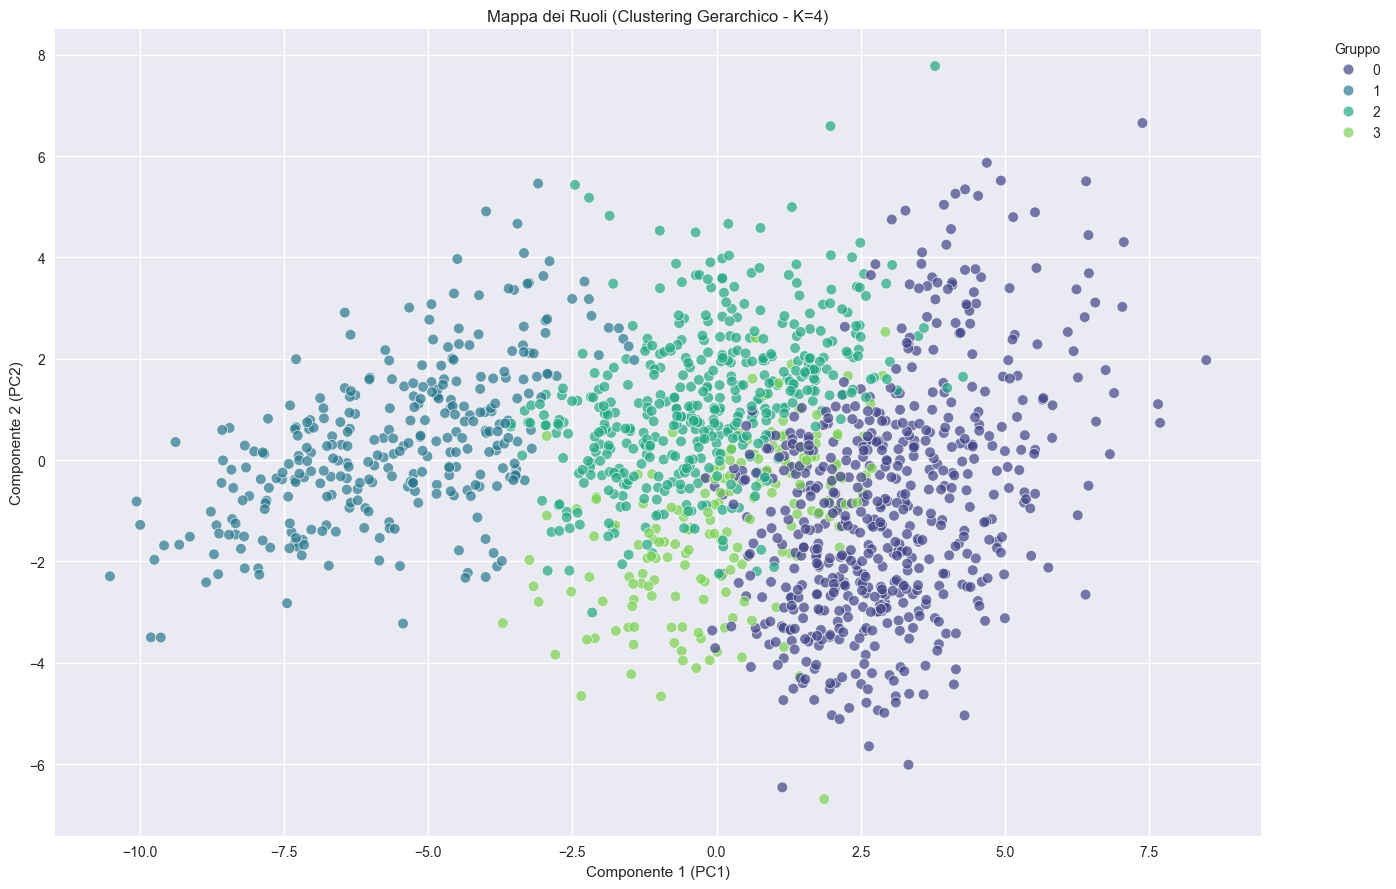

In [5]:
# Creiamo un DataFrame per il plottaggio
plot_df = pd.DataFrame(X_top_pca, columns=['PC1', 'PC2', 'PC3'])
plot_df['Cluster'] = df_top['Cluster_Gerarchico'].astype('category')

# Plotting
plt.figure(figsize=(14, 9))
ax = sns.scatterplot(
    data=plot_df,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='viridis',
    s=60,
    alpha=0.7,
    legend='full'
)

plt.title('Mappa dei Ruoli (Clustering Gerarchico - K=4)')
plt.xlabel('Componente 1 (PC1)')
plt.ylabel('Componente 2 (PC2)')
plt.legend(title='Gruppo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()